#Final Project Deep Learning 

Problem Statement:
Automatic story generation (ASG) involves the ability to generate coherent and engaging stories and has many potential applications, from creative writing to chatbots and virtual assistants. In recent years, it has gained a lot of popularity and is an active research area. 

Dataset: For this project, we will use the WritingPrompts dataset, which was released by Facebook Research. This contains over 300,000 short stories. We will use a part of this dataset, owing to the limited computing resources available, and split the dataset into training, validation, and test sets for training and evaluating our models.



Idea:

1.   We first load the WritingPrompts dataset 
2.   Preprocess the dataset
3.   Define the model architecture
4.   Train the Model
5.   Test the model
6.   Plot the graphs - accuracy and other metrics
8.   Compare the performance blue score, perplexity
9.   Identify the limitations of VAE


In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 41.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 43.3 MB/s eta 0:00:00


In [2]:
# import necessary packages
import os
import pandas as pd
import spacy
import torch
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch import optim
import pickle
from collections import Counter
from sklearn.model_selection import train_test_split
import torch.backends.cudnn as cudnn
import torchtext
from torchtext.utils import download_from_url
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from transformers import BertTokenizer
from torch.nn.utils.rnn import pad_sequence
import nltk
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Load the Dataset and Preprocess

For this project, we will use the WritingPrompts dataset, which was released by Facebook Research. This contains over 300,000 short stories. We will use a part of this dataset, owing to the limited computing resources available, and split the dataset into training, validation, and test sets for training and evaluating our models.

From https://github.com/facebookresearch/fairseq/tree/main/examples/stories 



In [4]:
data_dir = "/content/drive/MyDrive/Colab Notebooks/DL Final Project/Pickles-first10k/"

# Load the tokenized data from a file
with open(data_dir+'train_src_tokenized.pickle', 'rb') as f:
    train_src_tokenized = pickle.load(f)

with open(data_dir+'train_tgt_tokenized.pickle', 'rb') as f:
    train_tgt_tokenized = pickle.load(f)

with open(data_dir+'val_src_tokenized.pickle', 'rb') as f:
    val_src_tokenized = pickle.load(f)

with open(data_dir+'val_tgt_tokenized.pickle', 'rb') as f:
    val_tgt_tokenized = pickle.load(f)

with open(data_dir+'test_src_tokenized.pickle', 'rb') as f:
    test_src_tokenized = pickle.load(f)

with open(data_dir+'test_tgt_tokenized.pickle', 'rb') as f:
    test_tgt_tokenized = pickle.load(f)

Tokenize the data using BertTokenizer

In [5]:
from transformers import BertTokenizer

bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_src_tokenized_bert = [bert_tokenizer.encode(seq, add_special_tokens=True, max_length=512, truncation=True) for seq in train_src_tokenized]
train_tgt_tokenized_bert = [bert_tokenizer.encode(seq, add_special_tokens=True, max_length=512, truncation=True) for seq in train_tgt_tokenized]
val_src_tokenized_bert = [bert_tokenizer.encode(seq, add_special_tokens=True, max_length=512, truncation=True) for seq in val_src_tokenized]
val_tgt_tokenized_bert = [bert_tokenizer.encode(seq, add_special_tokens=True, max_length=512, truncation=True) for seq in val_tgt_tokenized]
test_src_tokenized_bert = [bert_tokenizer.encode(seq, add_special_tokens=True, max_length=512, truncation=True) for seq in test_src_tokenized]
test_tgt_tokenized_bert = [bert_tokenizer.encode(seq, add_special_tokens=True, max_length=512, truncation=True) for seq in test_tgt_tokenized]


Convert to tensors and pad them

In [6]:
train_src_tensor = [torch.tensor(seq) for seq in train_src_tokenized_bert]
train_tgt_tensor = [torch.tensor(seq) for seq in train_tgt_tokenized_bert]
val_src_tensor = [torch.tensor(seq) for seq in val_src_tokenized_bert]
val_tgt_tensor = [torch.tensor(seq) for seq in val_tgt_tokenized_bert]
test_src_tensor = [torch.tensor(seq) for seq in test_src_tokenized_bert]
test_tgt_tensor = [torch.tensor(seq) for seq in test_tgt_tokenized_bert]

train_src_padded = pad_sequence(train_src_tensor, batch_first=True)
train_tgt_padded = pad_sequence(train_tgt_tensor, batch_first=True)
val_src_padded = pad_sequence(val_src_tensor, batch_first=True)
val_tgt_padded = pad_sequence(val_tgt_tensor, batch_first=True)
test_src_padded = pad_sequence(test_src_tensor, batch_first=True)
test_tgt_padded = pad_sequence(test_tgt_tensor, batch_first=True)


class TranslationDataset(Dataset):
    def __init__(self, src_tensor, tgt_tensor):
        self.src_tensor = src_tensor
        self.tgt_tensor = tgt_tensor

    def __len__(self):
        return len(self.src_tensor)

    def __getitem__(self, idx):
        return self.src_tensor[idx], self.tgt_tensor[idx]

train_dataset = TranslationDataset(train_src_padded, train_tgt_padded)
val_dataset = TranslationDataset(val_src_padded, val_tgt_padded)
test_dataset = TranslationDataset(test_src_padded, test_tgt_padded)

batch_size = 16

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)


In [7]:
print(f"Tokenized length train => Source: {len(train_src_tokenized)}, Target: {len(train_tgt_tokenized)}")

Tokenized length train => Source: 10001, Target: 10001


# Define the model

Create an encoder and decoder layer




In [13]:
class VAE(nn.Module):
    def __init__(self, vocab_size_src, vocab_size_tgt, z_dim, rnn_hid_dim, num_layers, dropout=0.5):
        super().__init__()
        self.vocab_size_src = vocab_size_src
        self.vocab_size_tgt = vocab_size_tgt
        self.z_dim = z_dim
        self.rnn_hid_dim = rnn_hid_dim
        self.num_layers = num_layers
        
        self.src_embedding = nn.Embedding(vocab_size_src, rnn_hid_dim)
        self.tgt_embedding = nn.Embedding(vocab_size_tgt, rnn_hid_dim)
        
        self.encoder_rnn = nn.LSTM(rnn_hid_dim, rnn_hid_dim, num_layers, batch_first=True, dropout=dropout)
        self.decoder_rnn = nn.LSTM(rnn_hid_dim + z_dim, rnn_hid_dim, num_layers, batch_first=True, dropout=dropout)
        
        self.mu_linear = nn.Linear(rnn_hid_dim, z_dim)
        self.logvar_linear = nn.Linear(rnn_hid_dim, z_dim)
        
        self.decoder_linear = nn.Linear(rnn_hid_dim, vocab_size_tgt)
        
    def encode(self, src_input):
        batch_size = src_input.size(0)
        src_embedded = self.src_embedding(src_input)
        _, (last_hidden, _) = self.encoder_rnn(src_embedded)
        mu = self.mu_linear(last_hidden[-1])
        logvar = self.logvar_linear(last_hidden[-1])
        z = self.reparameterize(mu, logvar, batch_size)
        return mu, logvar, z
    
    def decode(self, tgt_input, z):
        batch_size, tgt_len = tgt_input.size()
        tgt_embedded = self.tgt_embedding(tgt_input)
        z_expanded = z.unsqueeze(1).expand(batch_size, tgt_len, self.z_dim)
        decoder_input = torch.cat((tgt_embedded, z_expanded), dim=2)
        decoder_output, _ = self.decoder_rnn(decoder_input)
        decoder_logits = self.decoder_linear(decoder_output)
        return decoder_logits

        
    def reparameterize(self, mu, logvar, batch_size):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn(batch_size, self.z_dim, device=mu.device)
        z = eps * std + mu
        return z
    
    def forward(self, src_input, tgt_input):
        mu, logvar, z = self.encode(src_input)
        decoder_logits = self.decode(tgt_input, z)
        return decoder_logits, mu, logvar


# Define the Hyperparameters

In [14]:
src_vocab = Counter(token for seq in train_src_tokenized for token in seq)
vocab_size_src = len(src_vocab)

tgt_vocab = Counter(token for seq in train_tgt_tokenized for token in seq)
vocab_size_tgt = len(tgt_vocab)

print(f"Vocab size => Source: {vocab_size_src}, Target: {vocab_size_tgt}")
z_dim = 64
rnn_hid_dim = 32
num_layers = 2
dropout = 0.5
lr = 0.01

model = VAE(vocab_size_tgt, vocab_size_tgt, z_dim, rnn_hid_dim, num_layers, dropout)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index=bert_tokenizer.pad_token_id)




Vocab size => Source: 13774, Target: 71443


# Train the Model

In [15]:
def bleu_score(model, dataloader, device):
    model.eval()
    references = []
    hypotheses = []

    with torch.no_grad():
        for src_batch, tgt_batch in dataloader:
            src_batch = torch.tensor(src_batch).long().to(device)
            tgt_batch = torch.tensor(tgt_batch).long().to(device)

    
            output, mu, logvar = model(src_batch, tgt_batch)
            output = output.argmax(2)
            for ref, hypo in zip(tgt_batch, output):
                references.append([ref.cpu().tolist()])
                hypotheses.append(hypo.cpu().tolist())

    return corpus_bleu(references, hypotheses)


In [16]:

def calculate_scores(model, dataloader, device):
    model.eval()
    references = []
    hypotheses = []
    references_decoded = []

    with torch.no_grad():
        for src_batch, tgt_batch in dataloader:
            src_batch = torch.tensor(src_batch).long().to(device)
            tgt_batch = torch.tensor(tgt_batch).long().to(device)

            output, mu, logvar = model(src_batch, tgt_batch)
            output = output.argmax(2)

            
            for ref, hypo in zip(tgt_batch, output):
                references.append([ref.cpu().tolist()])
                hypotheses.append(hypo.cpu().tolist())

    bleu_score = corpus_bleu(references, hypotheses)

    return bleu_score


In [17]:
import shutil
num_epochs = 30
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if device == 'cuda':
    model = nn.DataParallel(model)
    cudnn.benchmark = True

model = model.to(device)
criterion = criterion.to(device)

train_loss_list = []
train_bleu_list = []
train_acc_list = []
val_loss_list = []
val_bleu_list = []
train_perplexity = []
val_perplexity = []



for epoch in range(num_epochs):
    train_loss = 0
    train_acc = 0
    model.train()

    for src_batch, tgt_batch in train_dataloader:

        src_batch = torch.tensor(src_batch).long().to(device)
        tgt_batch = torch.tensor(tgt_batch).long().to(device)
        optimizer.zero_grad()
        output, mu, logvar = model(src_batch, tgt_batch)
        output = output.view(-1, vocab_size_tgt)
        tgt_batch = tgt_batch.view(-1)
        loss = criterion(output, tgt_batch)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    train_bleu = calculate_scores(model, train_dataloader, device)

    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader.dataset)

    train_loss_list.append(train_loss)
    
    train_perplexity.append(torch.exp(torch.tensor(train_loss)))
    train_bleu_list.append(train_bleu)
    train_acc_list.append(train_acc)

    val_loss = 0
    val_acc = 0
    model.eval()

    with torch.no_grad():
        for src_batch, tgt_batch in val_dataloader:

            src_batch = torch.tensor(src_batch).to(device)
            tgt_batch = torch.tensor(tgt_batch).to(device)

            output, mu, logvar = model(src_batch, tgt_batch)
            output = output.view(-1, vocab_size_tgt)
            tgt_batch = tgt_batch.view(-1)
            loss = criterion(output, tgt_batch)


            val_loss += loss.item()
        val_loss /= len(val_dataloader)
        val_bleu = calculate_scores(model, val_dataloader, device)

        val_loss_list.append(val_loss)
        val_perplexity.append(torch.exp(torch.tensor(val_loss)))
        val_bleu_list.append(val_bleu)

    print(f"Epoch {epoch+1}: train_loss={train_loss:.4f} train_bleu={train_bleu:.4f} \n \
            Epoch {epoch+1}: val_loss={val_loss:.4f} val_bleu={val_bleu:.4f}")
    model_path = "/content/vae_dl_project.pt"
    torch.save(model.state_dict(), model_path)
    drive_path = "/content/drive/MyDrive/vae_dl_project.pt"
    shutil.copyfile(model_path,drive_path)




<ipython-input-17-d982b7ef0be2>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src_batch = torch.tensor(src_batch).long().to(device)
<ipython-input-17-d982b7ef0be2>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tgt_batch = torch.tensor(tgt_batch).long().to(device)
<ipython-input-16-7ad1d4157a1b>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src_batch = torch.tensor(src_batch).long().to(device)
<ipython-input-16-7ad1d4157a1b>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() 

Epoch 1: train_loss=6.2488 train_bleu=0.0021 
             Epoch 1: val_loss=6.1529 val_bleu=0.0019
Epoch 2: train_loss=6.1569 train_bleu=0.0021 
             Epoch 2: val_loss=6.1522 val_bleu=0.0019
Epoch 3: train_loss=6.1364 train_bleu=0.0021 
             Epoch 3: val_loss=6.1281 val_bleu=0.0019
Epoch 4: train_loss=6.1191 train_bleu=0.0033 
             Epoch 4: val_loss=6.1131 val_bleu=0.0032
Epoch 5: train_loss=6.1097 train_bleu=0.0033 
             Epoch 5: val_loss=6.1085 val_bleu=0.0032
Epoch 6: train_loss=6.1057 train_bleu=0.0033 
             Epoch 6: val_loss=6.1031 val_bleu=0.0032
Epoch 7: train_loss=6.1027 train_bleu=0.0033 
             Epoch 7: val_loss=6.0988 val_bleu=0.0032
Epoch 8: train_loss=6.0985 train_bleu=0.0033 
             Epoch 8: val_loss=6.0967 val_bleu=0.0032
Epoch 9: train_loss=6.0961 train_bleu=0.0033 
             Epoch 9: val_loss=6.0960 val_bleu=0.0032
Epoch 10: train_loss=6.0939 train_bleu=0.0033 
             Epoch 10: val_loss=6.0976 val_bleu=0.003

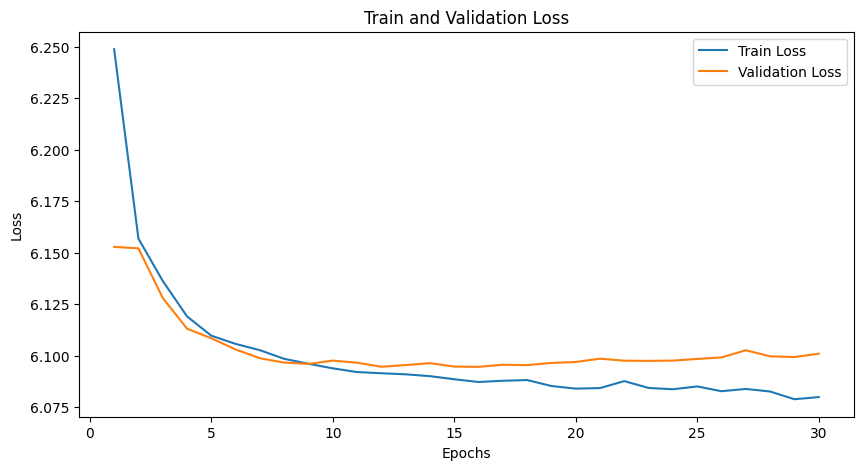

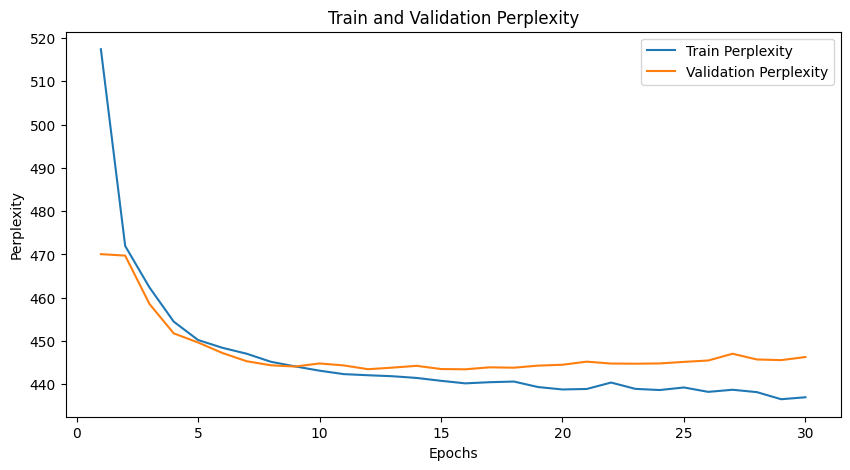

In [18]:

import matplotlib.pyplot as plt
epochs = range(1, num_epochs+1)

# Plotting train loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss_list, label='Train Loss')
plt.plot(epochs, val_loss_list, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()


# Plotting train perplexity
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_perplexity, label='Train Perplexity')
plt.plot(epochs, val_perplexity, label='Validation Perplexity')
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.title('Train and Validation Perplexity')
plt.legend()
plt.show()

In [19]:
test_bleuscore = bleu_score(model, test_dataloader, device)
print(test_bleuscore)

<ipython-input-15-3b9c78d3e074>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src_batch = torch.tensor(src_batch).long().to(device)
<ipython-input-15-3b9c78d3e074>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tgt_batch = torch.tensor(tgt_batch).long().to(device)


0.0019648955627610066


In [20]:
print(test_bleuscore)

0.0019648955627610066


In [21]:
def tokenize_prompt(prompt, src_tokenizer, device):
    tokens = src_tokenizer.encode(prompt)
    token_tensor = torch.tensor(tokens).long().unsqueeze(0).to(device)  # Add batch dimension
    return token_tensor

In [22]:
def tokens_to_text(tokens, tgt_tokenizer):
    return tgt_tokenizer.decode(tokens)

In [23]:
def generate_text(model, prompt, device, max_length=100):
    src_input = bert_tokenizer.encode(prompt, add_special_tokens=True, max_length=max_length, truncation=True)
    src_input = torch.tensor(src_input).to(device).unsqueeze(0)
    desired_length = max_length

    generated_sequence = torch.zeros(1, max_length).long().to(device) 

    for i in range(max_length):
        output, _, _ = model(src_input, generated_sequence)
        next_token = output[:, i].argmax(1)
        generated_sequence[:, i] = next_token

    generated_tokens = generated_sequence.squeeze(0).tolist() 
    generated_text = bert_tokenizer.decode(generated_tokens, skip_special_tokens=True)
    

    return generated_text


In [33]:
# prompt = "load the model"
prompt = "It has been a long day"
print("Prompt: ", prompt)
generated_text = generate_text(model, prompt, device, 10)
print("Generated text: ", generated_text)


Prompt:  It has been a long day
Generated text:  power high doing high high


# Conclusion

The generated text by this model does not make any sense, it has a very high perplexity score and there is no coherency in the generated text. We have to make more modifications to this.